<a href="https://colab.research.google.com/github/michelbarboza/ERA5-Temperature-Prediction/blob/main/XGBoost_(GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ERA5-Temperature-Prediction/Dados/'

# Preprocessing

In [ ]:
with open(path+'train.pkl', 'rb') as f:
    train = pickle.load(f)

with open(path+'test.pkl', 'rb') as f:
    test = pickle.load(f)

del f

In [ ]:
targets = ['target_1', 'target_3', 'target_5',
           'target_7', 'target_10', 'target_15']

features = train.columns.difference(targets)

In [ ]:
train[targets] = train[targets] - 273.15
test[targets] = test[targets] - 273.15

In [ ]:
target = 'target_1'

In [ ]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


# Extreme Gradient Boosting

In [ ]:
# Define the XGBoost parameters for using CUDA
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'nthread': -1,
    'verbosity': 2,
    'eta': 0.1

}

# Perform cross-validation on the training data
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10_000,
    nfold=5,
    metrics='rmse',
    early_stopping_rounds=1000,
    seed=42,
    as_pandas=True,
    verbose_eval=True
)

# Train the model on the full training data using the number of rounds found in cross-validation
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=len(cv_results)
)

# Predict on the test set
y_pred = model.predict(dtest)

# Evaluate the model performance on the test set using RMSE
test_rmse = np.sqrt(mean_squared_error(dtest.get_label(), y_pred))
print(f'RMSE on test data: {test_rmse}')

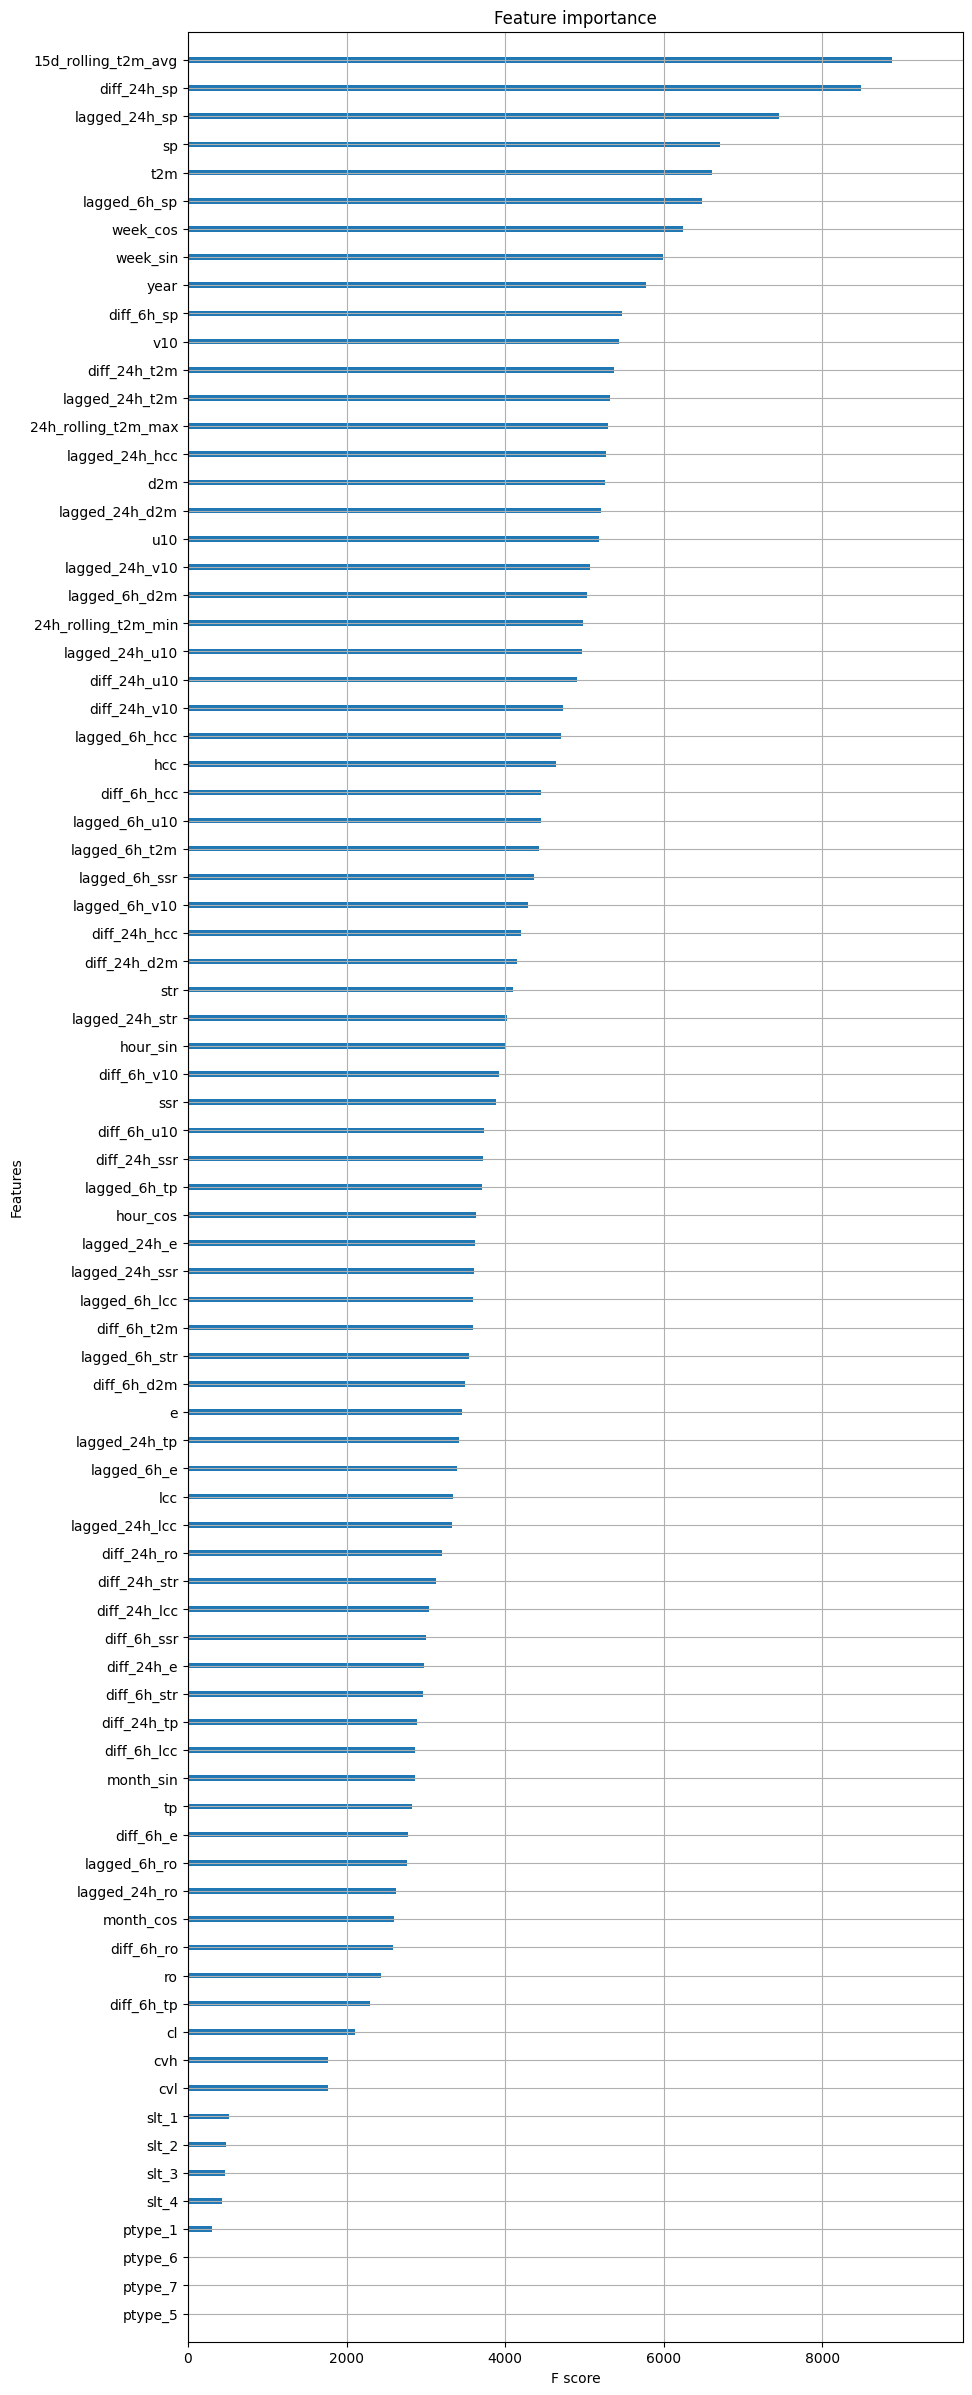

In [ ]:
# Plot feature importance
xgb.plot_importance(model, importance_type='weight', show_values=False, height=0.2)
plt.rcParams['figure.figsize'] = [10, 30]
plt.show()

In [ ]:
# Save lists using pickle
with open(path+'pred_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(y_test_pred, f)

with open(path+'rmse_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(rmse_test, f)

with open(path+'best_params_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(best_params, f)

# 95th percentile loss function

In [ ]:
# Define the evaluation metric for the 95th percentile
def quantile_eval(preds, dtrain):
    tau = 0.95
    labels = dtrain.get_label()
    errors = labels - preds
    quantile_loss = np.mean(np.maximum(tau * errors, (tau - 1) * errors))
    return 'quantile_loss', quantile_loss

# Update the XGBoost parameters
params = {
    'objective': 'reg:absoluteerror',
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'nthread': -1,
    'verbosity': 2,
    'eta': 0.1,
    'alpha': 0.95
}

# Perform cross-validation on the training data
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10_000,
    nfold=5,
    custom_metric=quantile_eval,
    early_stopping_rounds=1000,
    seed=42,
    as_pandas=True,
    verbose_eval=True
)

# Train the model on the full training data using the number of rounds found in cross-validation
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=len(cv_results),
    custom_metric=quantile_eval
)

# Predict on the test set
y_pred = model.predict(dtest)

# Evaluate the model performance on the test set using RMSE
test_rmse = np.sqrt(mean_squared_error(dtest.get_label(), y_pred))
print(f'RMSE on test data: {test_rmse}')


NameError: name 'xgb' is not defined

In [ ]:
# Save lists using pickle
with open(path+'95_pred_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open(path+'95_rmse_xgb_'+target+'.pkl', 'wb') as f:
    pickle.dump(test_rmse, f)

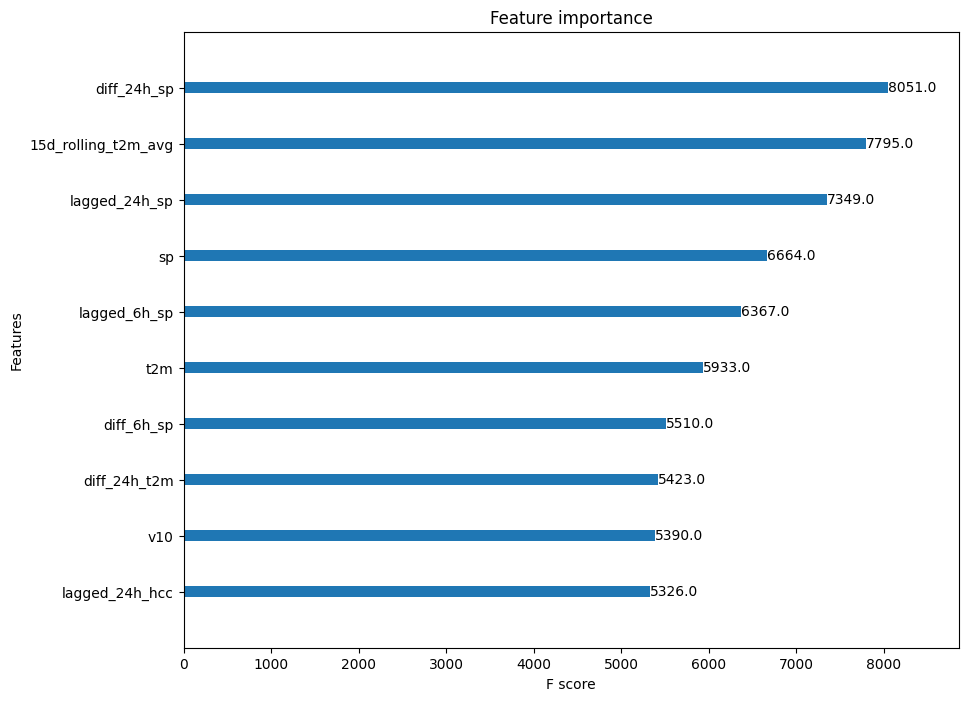

In [ ]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', ax=ax, max_num_features=10, grid=False)
plt.show()

# Residuals

In [ ]:
residuals = y_test - y_pred

percentile_95 = np.percentile(y_test, 95)
mask = y_test > percentile_95
residuals_95th = y_test[mask] - y_pred[mask]


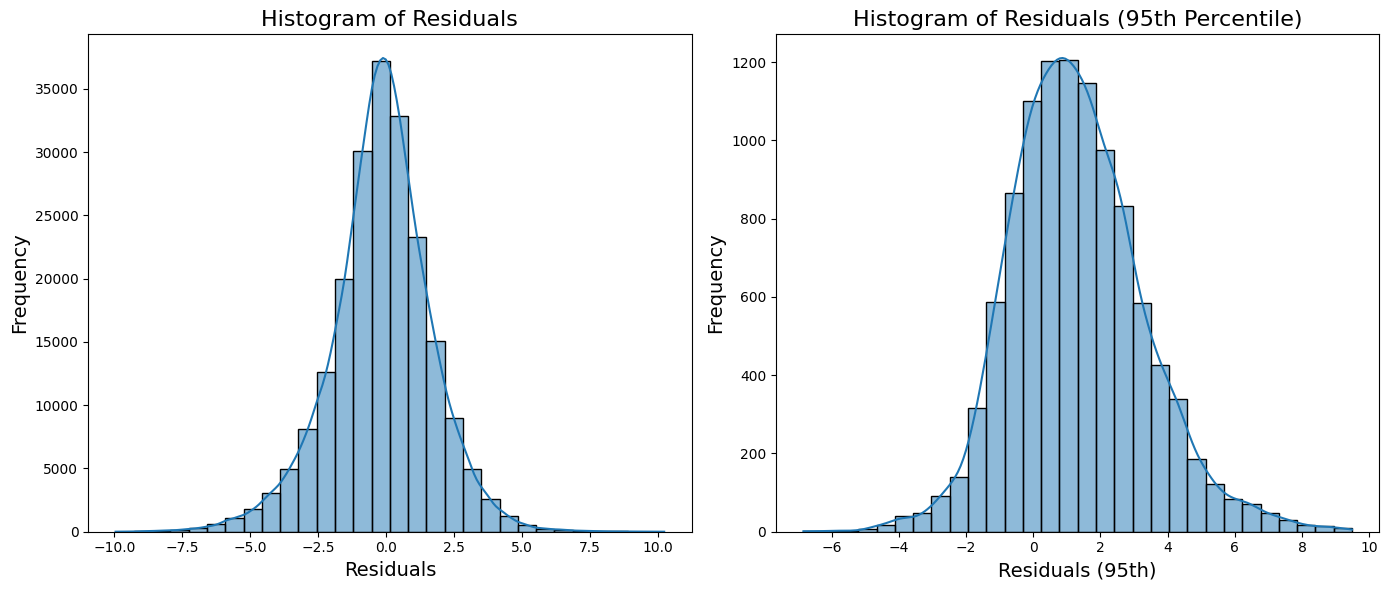

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(residuals, kde=True, bins=30, ax=axes[0])
axes[0].set_title('Histogram of Residuals', fontsize=16)
axes[0].set_xlabel('Residuals', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)

sns.histplot(residuals_95th, kde=True, bins=30, ax=axes[1])
axes[1].set_title('Histogram of Residuals (95th Percentile)', fontsize=16)
axes[1].set_xlabel('Residuals (95th)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

plt.show()


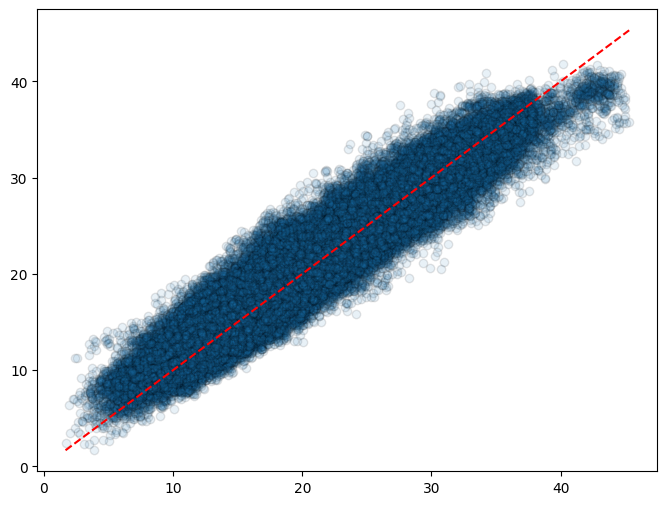

In [ ]:
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1, edgecolor='k', label='Predictions')

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

plt.show()
